In [5]:
import csv
import json
import os
import requests
import unicodedata

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn
import yfinance as yf

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in the notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
ticker_symbol = 'AAPL'
start_date = '2017-01-01'
end_date = '2020-12-31'

In [7]:
def acquireStockData(ticker_symbol, start_date, end_date):
    try:
        print(f'[Info] Acquiring data for ticker symbol [{ticker_symbol}] between {start_date} and {end_date}...'
        )
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
        print('[Info] The stock data has {} samples with {} features each.'.
              format(*stock_data.shape))
        return stock_data
    except Exception as ex:
        print(ex)
        print('[Error] Stock data could not be acquired.')

In [8]:
stock_data = acquireStockData(ticker_symbol, start_date, end_date)

[Info] Acquiring data for ticker symbol [AAPL] between 2017-01-01 and 2020-12-31...
[*********************100%***********************]  1 of 1 completed
[Info] The stock data has 1006 samples with 6 features each.


In [9]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332474,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301876,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440716,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746635,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000786,134247600
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157608,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161407,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852509,124486200


In [22]:
home_dir = os.path.abspath(os.curdir)  # '/Users/friedrich/Projects/DAPS_assignment/code'
stock_file_path = os.path.join(home_dir, 'data', 'stock_data.csv')

stock_data.to_csv(stock_file_path, index=True)

In [23]:
with open(stock_file_path, 'r') as csvfile:
    df = pd.read_csv(stock_file_path,
                     index_col='Date',
                     usecols=[
                         'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
                     ])

In [24]:
# Use a bit more data to calculate the interpolation
idx = pd.date_range('2017-01-01', '2020-12-31')
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, fill_value=np.NaN)

interpolated_df = df.interpolate()  # method='linear' by default
print(f'{(interpolated_df.count() - df.count())[0]} samples have been interpolated.'
)

stock_df = interpolated_df.loc['2017-04-01':'2020-05-31']

453 samples have been interpolated.


In [25]:
stock_df

,Open,High,Low,Close,Adj Close,Volume
2017-04-01,35.929167,36.055000,35.755833,35.918334,33.955856,7.907880e+07
2017-04-02,35.928335,36.042500,35.759167,35.921666,33.959007,7.951080e+07
2017-04-03,35.927502,36.029999,35.762501,35.924999,33.962158,7.994280e+07
2017-04-04,35.812500,36.222500,35.792500,36.192501,34.215042,7.956560e+07
2017-04-05,36.055000,36.365002,35.952499,36.005001,34.037785,1.108716e+08
...,...,...,...,...,...,...
2020-05-27,79.035004,79.677498,78.272499,79.527496,78.762093,1.129452e+08
2020-05-28,79.192497,80.860001,78.907501,79.562500,78.796761,1.335608e+08
2020-05-29,79.812500,80.287498,79.117500,79.485001,78.720001,1.535324e+08
2020-05-30,79.687500,80.387499,79.179166,79.810834,79.042697,1.292853e+08


Z-score: 
 2017-04-01    1.215251
2017-04-02    1.214993
2017-04-03    1.214735
2017-04-04    1.194028
2017-04-05    1.208542
                ...   
2020-05-27    2.453542
2020-05-28    2.456381
2020-05-29    2.450096
2020-05-30    2.476518
2020-05-31    2.502941
Freq: D, Name: Adj Close, Length: 1157, dtype: float64


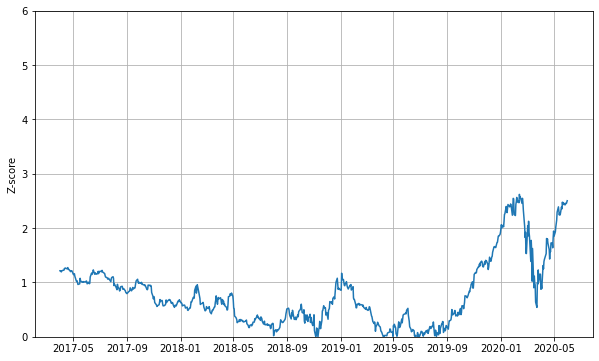

In [26]:
outlier_dataset = stock_df['Adj Close']
outlier_year = stock_df.index

# Calculate the absolute value of Z-score
z = np.abs(stats.zscore(outlier_dataset))

print('Z-score: \r\n', z)

plt.plot(outlier_year, z)
plt.grid()
plt.ylim([0, 6])
plt.ylabel('Z-score')
plt.show()

In [27]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1.157000e+03
mean,50.171359,50.702559,49.706663,50.236025,48.797472,1.278580e+08
std,11.850798,12.094712,11.722214,11.952120,12.218081,5.808507e+07
min,35.305000,35.470001,35.014999,35.169998,33.248405,4.544800e+07
25%,41.740002,42.250000,41.245832,41.722500,40.105247,8.748120e+07
50%,46.947498,47.317501,46.597501,47.037498,45.440826,1.130776e+08
75%,55.164998,55.665000,54.412498,55.105000,53.717419,1.494147e+08
max,81.184998,81.962502,80.837502,81.800003,80.794014,4.265100e+08


In [28]:
for col in list(stock_df.columns.values):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = stock_df.drop(col, axis=1)

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data,
                                                        stock_df[col],
                                                        test_size=0.3,
                                                        random_state=2020)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("{} R^2 score: {:2f}".format(col, score))

Open R^2 score: 0.998301
High R^2 score: 0.998529
Low R^2 score: 0.998663
Close R^2 score: 0.999512
Adj Close R^2 score: 0.999139
Volume R^2 score: 0.359728


In [29]:
del stock_df['Open']
del stock_df['High']
del stock_df['Low']
del stock_df['Close']
del stock_df['Volume']
stock_df

,Adj Close
2017-04-01,33.955856
2017-04-02,33.959007
2017-04-03,33.962158
2017-04-04,34.215042
2017-04-05,34.037785
...,...
2020-05-27,78.762093
2020-05-28,78.796761
2020-05-29,78.720001
2020-05-30,79.042697


In [30]:
def prepare_data(data, target_feature): 
    """
    prepare the data for ingestion by fbprophet: 
    see: https://facebook.github.io/prophet/docs/quick_start.html
    """
    new_data = data.copy()
    new_data.reset_index(inplace=True)
    new_data = new_data.rename({'index':'ds', '{}'.format(target_feature):'y'}, axis=1)
    
    return new_data

In [31]:
new_stock_df = prepare_data(data=stock_df, target_feature='Adj Close')

new_stock_df.head(5)

,ds,y
0,2017-04-01,33.955856
1,2017-04-02,33.959007
2,2017-04-03,33.962158
3,2017-04-04,34.215042
4,2017-04-05,34.037785


In [32]:
def my_train_test_split(data):
    train = data.set_index('ds').loc[:'2020-04-30', :].reset_index()
    test = data.set_index('ds').loc['2020-05-01':, :].reset_index()

    return train, test

In [33]:
train, test = my_train_test_split(data=new_stock_df)

train.tail()

,ds,y
1121,2020-04-26,69.905434
1122,2020-04-27,69.921898
1123,2020-04-28,68.788498
1124,2020-04-29,71.047874
1125,2020-04-30,72.546707


In [34]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)

In [35]:
m.fit(train)

In [36]:
future = m.make_future_dataframe(periods=len(test), freq='1D')
future.head()

,ds
0,2017-04-01
1,2017-04-02
2,2017-04-03
3,2017-04-04
4,2017-04-05


In [37]:
forecast = m.predict(future)

In [38]:
def make_predictions_df(forecast, data_train, data_test):
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    """
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:, 'y'] = data.loc[:, 'y']

    return forecast

In [39]:
result = make_predictions_df(forecast, train, test)
result.loc[:, 'yhat'] = result.yhat.clip(lower=0)
result.loc[:, 'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,
2017-04-01,2017-04-01,35.145391,31.062291,35.526802,35.145391,35.145391,-0.053333,-0.053333,-0.053333,-0.000939,-0.000939,-0.000939,-0.052394,-0.052394,-0.052394,0.0,0.0,0.0,33.270979,33.955856
2017-04-02,2017-04-02,35.195532,31.074544,35.518216,35.195532,35.195532,-0.051938,-0.051938,-0.051938,-0.001704,-0.001704,-0.001704,-0.050233,-0.050233,-0.050233,0.0,0.0,0.0,33.367552,33.959007
2017-04-03,2017-04-03,35.245673,31.322806,35.662737,35.245673,35.245673,-0.050391,-0.050391,-0.050391,-0.002474,-0.002474,-0.002474,-0.047917,-0.047917,-0.047917,0.0,0.0,0.0,33.469602,33.962158
2017-04-04,2017-04-04,35.295814,31.698132,35.971364,35.295814,35.295814,-0.045563,-0.045563,-0.045563,-0.000069,-0.000069,-0.000069,-0.045494,-0.045494,-0.045494,0.0,0.0,0.0,33.687615,34.215042
2017-04-05,2017-04-05,35.345955,31.853462,36.198768,35.345955,35.345955,-0.039956,-0.039956,-0.039956,0.003054,0.003054,0.003054,-0.043010,-0.043010,-0.043010,0.0,0.0,0.0,33.933686,34.037785


In [40]:
def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(14, 8))

    train = forecast.loc[start_date:'2020-04-30', :]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index,
                    train.yhat_lower,
                    train.yhat_upper,
                    color='steelblue',
                    alpha=0.3)

    test = forecast.loc['2020-05-01':, :]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index,
                    test.yhat_lower,
                    test.yhat_upper,
                    color='coral',
                    alpha=0.3)
    ax.axvline(forecast.loc['2020-05-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)

    return f, ax

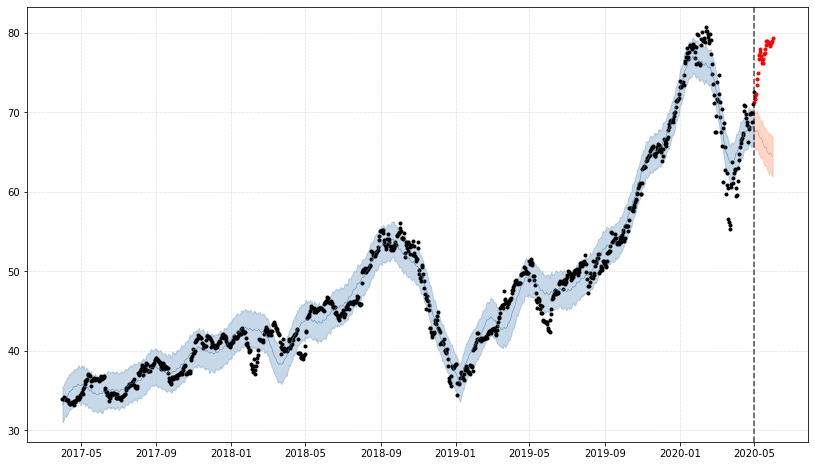

In [41]:
f, ax = plot_predictions(result, '2017-04-01')

C:\Users\Tharun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.05, 0.85, 'Skewness = +0.77\nMedian = -11.31\nMean = -10.68')

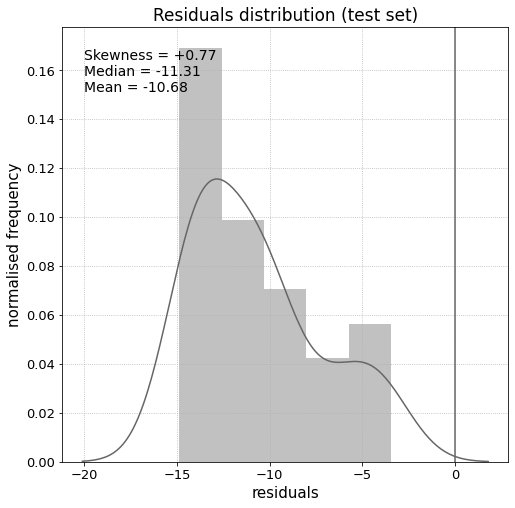

In [42]:
residuals = result.loc['2020-05-01':, 'yhat'] - result.loc['2020-05-01':, 'y']

f, ax = plt.subplots(figsize=(8, 8))
sn.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(stats.skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

In [43]:
print('Mean Squared Error:', MSE(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))
print('Mean Absolute Error:', MAE(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))
print('R-Squared:', R2(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))


Mean Squared Error: 125.73555042877923
Mean Absolute Error: 10.682453586759324
R-Squared: -21.61481640135096


In [44]:
api_key = 'sH5ntfNgSN9UcR5gpbuYQqlee3DrmLbC'

# Since the Archive API can only be searched by month and year,
# we have to acquire and prepare all articles in the four years for further preprocessing.
years = [2017, 2018, 2019, 2020]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [45]:
class NoAPIKeyException(Exception):
    def __init__(self, message):
        self.message = message


class InvalidQueryException(Exception):
    def __init__(self, message):
        self.message = message


class ArchiveAPI(object):
    def __init__(self, key=None):
        """
        Initializes the ArchiveAPI class. Raises an exception if no API key is given.
        :param key: New York Times API Key
        """
        self.key = key
        self.root = 'http://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}'
        if not self.key:
            nyt_dev_page = 'http://developer.nytimes.com/docs/reference/keys'
            exception_str = '[Error] API Key required. Please visit {}'
            raise NoAPIKeyException(exception_str.format(nyt_dev_page))

    def query(self, year=None, month=None, key=None):
        """
        Calls the archive API and returns the results as a dictionary.
        :param key: Defaults to the API key used to initialize the ArchiveAPI class.
        """
        if not key:
            key = self.key
        if (year < 1851) or not (0 < month < 13):
            # Currently the Archive API only supports year >= 1851
            nyt_dev_page = 'http://developer.nytimes.com/archive_api.json'
            exception_str = '[Error] Invalid query. Please visit {}'
            raise InvalidQueryException(exception_str.format(nyt_dev_page))
        url = self.root.format(year, month, key)
        r = requests.get(url)
        return r.json()


In [46]:
api = ArchiveAPI(api_key)

home_dir = os.path.abspath(os.curdir)  # '/Users/friedrich/Projects/DAPS_assignment/code'
article_file_dir = os.path.join(home_dir, 'data', 'articles')

In [47]:
for year in years:
    for month in months:
        query_dict = api.query(year, month)

        article_file_name = 'nytimes_' + str(year) + '-' + '{:02}'.format(month) + '.json'
        article_file_path = os.path.join(article_file_dir, article_file_name)
        print(f'[Info] Saving articles of {year}-{month} into {article_file_path} ...'
        )
        with open(article_file_path, 'w') as f:
            json.dump(query_dict, f)
        f.close()

KeyboardInterrupt: 

In [48]:
from datetime import datetime


def parseDate(text):
    date_format = ["%Y-%m-%dT%H:%M:%SZ", "%Y-%m-%dT%H:%M:%S+%f", "%Y-%m-%d"]

    for fmt in date_format:
        try:
            return datetime.strptime(text, fmt).strftime('%Y-%m-%d')
        except ValueError:
            pass
            # print('[Error] No valid date format available.')

In [49]:
years = [2017, 2018, 2019, 2020]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# years = [2017]
# months = [1]

dict_keys = ['pub_date', 'abstract']
articles_dict = dict.fromkeys(dict_keys)

# Filter list for type_of_material
type_of_material_list = [
    'blog', 'brief', 'news', 'editorial', 'op-ed', 'list', 'analysis'
]
# Filter list for keyword
keyword_list = ['apple inc']

# Add an article column to dataframe
interpolated_df["articles"] = ''

count_total_articles = 0
count_articles_filtered = 0
count_dict_keys_not_exist = 0

for year in years:
    for month in months:
        print(f'[Info] Processing articles of {year}-{month} ...')

        article_file_name = 'nytimes_' + \
            str(year) + '-' + '{:02}'.format(month) + '.json'
        article_file_path = os.path.join(article_file_dir, article_file_name)

        # Load the articles data
        with open(article_file_path) as data_file:
            NYTimes_data = json.load(data_file)

        docs = NYTimes_data["response"]["docs"][:]

        count_total_articles = count_total_articles + len(docs)

        for i in range(len(docs)):
            try:
                if any(substring in docs[i]['type_of_material'].lower()
                       for substring in type_of_material_list):
                    for j in range(len(docs[i]['keywords'][:])):
                        if any(docs[i]['keywords'][:][j]['value'].lower() in
                               keyword_list):
                            count_articles_filtered += 1
                            articles_dict = {
                                dict_key: docs[i][dict_key]
                                for dict_key in dict_keys
                            }
                            date = parseDate(articles_dict['pub_date'])
                            abstract = articles_dict['abstract']
                            interpolated_df.at[date, 'articles'] = abstract

            except KeyError:
                count_dict_keys_not_exist += 1

print('[Info] Total articles:', count_total_articles)
print('[Info] Articles after filtering: ', count_articles_filtered)
print('[Info] Articles with pub_date or abstract missing: ',
      count_dict_keys_not_exist)

stock_article_df = interpolated_df.loc['2017-04-01':'2020-05-31']


[Info] Processing articles of 2017-1 ...
[Info] Processing articles of 2017-2 ...
[Info] Processing articles of 2017-3 ...
[Info] Processing articles of 2017-4 ...
[Info] Processing articles of 2017-5 ...
[Info] Processing articles of 2017-6 ...
[Info] Processing articles of 2017-7 ...
[Info] Processing articles of 2017-8 ...
[Info] Processing articles of 2017-9 ...
[Info] Processing articles of 2017-10 ...
[Info] Processing articles of 2017-11 ...
[Info] Processing articles of 2017-12 ...
[Info] Processing articles of 2018-1 ...
[Info] Processing articles of 2018-2 ...
[Info] Processing articles of 2018-3 ...
[Info] Processing articles of 2018-4 ...
[Info] Processing articles of 2018-5 ...
[Info] Processing articles of 2018-6 ...
[Info] Processing articles of 2018-7 ...
[Info] Processing articles of 2018-8 ...
[Info] Processing articles of 2018-9 ...
[Info] Processing articles of 2018-10 ...
[Info] Processing articles of 2018-11 ...
[Info] Processing articles of 2018-12 ...
[Info] Pro

In [50]:
stock_article_df

,Open,High,Low,Close,Adj Close,Volume,articles
2017-04-01,35.929167,36.055000,35.755833,35.918334,33.955856,7.907880e+07,
2017-04-02,35.928335,36.042500,35.759167,35.921666,33.959007,7.951080e+07,Artists and brands are collaborating on advert...
2017-04-03,35.927502,36.029999,35.762501,35.924999,33.962158,7.994280e+07,
2017-04-04,35.812500,36.222500,35.792500,36.192501,34.215042,7.956560e+07,
2017-04-05,36.055000,36.365002,35.952499,36.005001,34.037785,1.108716e+08,
...,...,...,...,...,...,...,...
2020-05-27,79.035004,79.677498,78.272499,79.527496,78.762093,1.129452e+08,
2020-05-28,79.192497,80.860001,78.907501,79.562500,78.796761,1.335608e+08,
2020-05-29,79.812500,80.287498,79.117500,79.485001,78.720001,1.535324e+08,
2020-05-30,79.687500,80.387499,79.179166,79.810834,79.042697,1.292853e+08,


In [51]:
df = stock_article_df[['Adj Close']].copy()

# Add new columns to the dataframe
df["Compound"] = ''
df["Neg"] = ''
df["Neu"] = ''
df["Pos"] = ''

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
for date, row in stock_article_df.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', stock_article_df.loc[date, 'articles'])
        ss = sia.polarity_scores(sentence)
        df.at[date, 'Compound'] = ss['compound']
        df.at[date, 'Neg'] = ss['neg']
        df.at[date, 'Neu'] = ss['neu']
        df.at[date, 'Pos'] = ss['pos']
    except TypeError:
        print(stock_article_df.loc[date, 'articles'])
        print(date)

stock_sentiment_df = df.copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tharun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [52]:
stock_sentiment_df

,Adj Close,Compound,Neg,Neu,Pos
2017-04-01,33.955856,0.0,0.0,0.0,0.0
2017-04-02,33.959007,0.7717,0.0,0.789,0.211
2017-04-03,33.962158,0.0,0.0,0.0,0.0
2017-04-04,34.215042,0.0,0.0,0.0,0.0
2017-04-05,34.037785,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-05-27,78.762093,0.0,0.0,0.0,0.0
2020-05-28,78.796761,0.0,0.0,0.0,0.0
2020-05-29,78.720001,0.0,0.0,0.0,0.0
2020-05-30,79.042697,0.0,0.0,0.0,0.0


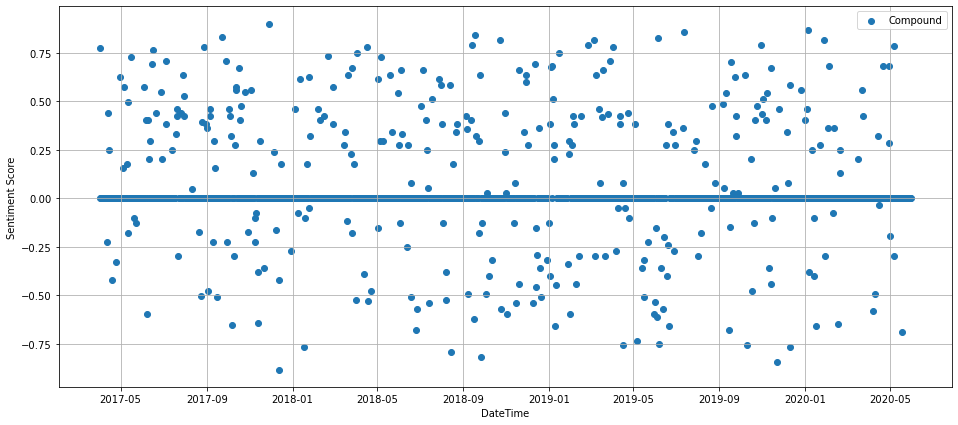

In [53]:
plt.figure(figsize=(16, 7))
plt.scatter(stock_sentiment_df.index,
            stock_sentiment_df['Compound'],
            label='Compound')

plt.xlabel('DateTime')
plt.ylabel('Sentiment Score')

plt.grid()
plt.legend()
plt.show()

In [54]:
pos = 0
neg = 0
neu = 0
no_article = 0

for i in range(0, len(stock_sentiment_df)):
    get_val = stock_sentiment_df.Compound[i]
    get_val_neu = stock_sentiment_df.Neu[i]
    if float(get_val) <= -0.05:
        neg += 1
    elif float(get_val) >= 0.05:
        pos += 1
    elif float(get_val) > -0.05 and float(get_val) < 0.05 and float(get_val_neu) == 1:
        neu += 1
    else:
        no_article += 1

pos_per = (pos / (len(stock_sentiment_df))) * 100
neg_per = (neg / (len(stock_sentiment_df))) * 100
neu_per = (neu / (len(stock_sentiment_df))) * 100
no_article_per = (no_article / (len(stock_sentiment_df))) * 100

print(f'{pos_per}% positive articles')
print(f'{neg_per}% negative articles')
print(f'{neu_per}% neural articles')
print(f'{no_article_per}% no articles at that day')

arr = np.asarray([pos_per, neg_per, neu_per, no_article_per], dtype=int)

17.28608470181504% positive articles
10.8038029386344% negative articles
9.593777009507347% neural articles
62.31633535004322% no articles at that day


In [55]:
ticker_symbol = '^IXIC'
start_date = '2017-01-01'
end_date = '2020-12-31'

market_data = acquireStockData(ticker_symbol, start_date, end_date)

market_data

[Info] Acquiring data for ticker symbol [^IXIC] between 2017-01-01 and 2020-12-31...
[*********************100%***********************]  1 of 1 completed
[Info] The stock data has 1006 samples with 6 features each.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,5425.620117,5452.569824,5397.990234,5429.080078,5429.080078,1886200000
2017-01-04,5440.910156,5482.350098,5440.240234,5477.000000,5477.000000,1883360000
2017-01-05,5474.390137,5495.850098,5464.359863,5487.939941,5487.939941,1792610000
2017-01-06,5499.080078,5536.520020,5482.810059,5521.060059,5521.060059,1710770000
2017-01-09,5527.580078,5541.080078,5517.140137,5531.819824,5531.819824,1885500000
...,...,...,...,...,...,...
2020-12-23,12834.940430,12841.919922,12758.669922,12771.110352,12771.110352,7028650000
2020-12-24,12791.540039,12833.549805,12767.639648,12804.730469,12804.730469,3305950000
2020-12-28,12914.639648,12930.889648,12827.450195,12899.419922,12899.419922,5076340000


In [56]:
home_dir = os.path.abspath(os.curdir) 
market_file_path = os.path.join(home_dir, 'data', 'market_data.csv')

market_data.to_csv(market_file_path, index=True)

In [57]:
with open(market_file_path, 'r') as csvfile:
    df = pd.read_csv(market_file_path, index_col='Date', usecols=['Date', 'Adj Close'])

In [58]:
# Use the data more than required to calculate the interpolation
idx = pd.date_range('2017-01-01', '2020-12-31')
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, fill_value=np.NaN)

interpolated_df = df.interpolate()  # method='linear' by default
print(f'{(interpolated_df.count() - df.count())[0]} samples have been interpolated.'
)

interpolated_df = interpolated_df.rename(
    columns={'Adj Close': 'Adj Close_NasDaq'})
market_df = interpolated_df.loc['2017-04-01':'2020-05-31']

453 samples have been interpolated.


In [59]:
market_df

,Adj Close_NasDaq
2017-04-01,5906.053548
2017-04-02,5900.366862
2017-04-03,5894.680176
2017-04-04,5898.609863
2017-04-05,5864.479980
...,...
2020-05-27,9412.360352
2020-05-28,9368.990234
2020-05-29,9489.870117
2020-05-30,9510.596680


In [60]:
stock_sentiment_market_df = stock_sentiment_df.join(market_df)
del stock_sentiment_market_df['Neg']
del stock_sentiment_market_df['Neu']
del stock_sentiment_market_df['Pos']

stock_sentiment_market_df

,Adj Close,Compound,Adj Close_NasDaq
2017-04-01,33.955856,0.0,5906.053548
2017-04-02,33.959007,0.7717,5900.366862
2017-04-03,33.962158,0.0,5894.680176
2017-04-04,34.215042,0.0,5898.609863
2017-04-05,34.037785,0.0,5864.479980
...,...,...,...
2020-05-27,78.762093,0.0,9412.360352
2020-05-28,78.796761,0.0,9368.990234
2020-05-29,78.720001,0.0,9489.870117
2020-05-30,79.042697,0.0,9510.596680


In [61]:
stock_sentiment_market_df.describe()

,Adj Close,Adj Close_NasDaq
count,1157.000000,1157.000000
mean,48.797472,7515.463309
std,12.218081,879.848918
min,33.248405,5805.149902
25%,40.105247,6903.390137
50%,45.440826,7505.919922
75%,53.717419,8030.040039
max,80.794014,9817.179688


In [62]:
for col in list(stock_sentiment_market_df.columns.values):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = stock_sentiment_market_df.drop(col, axis=1)

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(
        new_data,
        stock_sentiment_market_df[col],
        test_size=0.3,
        random_state=2020)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=2020)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("{} R^2 score: {:2f}".format(col, score))

Adj Close R^2 score: 0.827980
Compound R^2 score: -0.640133
Adj Close_NasDaq R^2 score: 0.874726


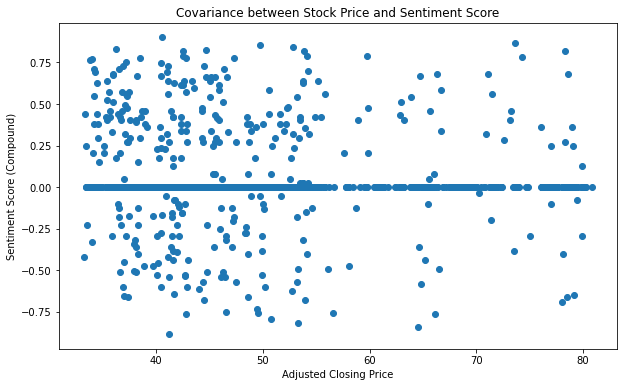

In [63]:
x = stock_sentiment_market_df['Adj Close']
y = stock_sentiment_market_df['Compound']
plt.scatter(x,y)
plt.title('Covariance between Stock Price and Sentiment Score')
plt.xlabel('Adjusted Closing Price')
plt.ylabel('Sentiment Score (Compound)')
plt.show()

In [64]:
new_stock_sentiment_market_df = prepare_data(data=stock_sentiment_market_df, target_feature='Adj Close')

new_stock_sentiment_market_df.head(5)

,ds,y,Compound,Adj Close_NasDaq
0,2017-04-01,33.955856,0.0,5906.053548
1,2017-04-02,33.959007,0.7717,5900.366862
2,2017-04-03,33.962158,0.0,5894.680176
3,2017-04-04,34.215042,0.0,5898.609863
4,2017-04-05,34.037785,0.0,5864.479980


In [65]:
def my_train_test_split(data):
    train = data.set_index('ds').loc[:'2020-04-30', :].reset_index()
    test = data.set_index('ds').loc['2020-05-01':, :].reset_index()
    
    return train, test

In [66]:
train, test = my_train_test_split(data=new_stock_sentiment_market_df)
train.head()

,ds,y,Compound,Adj Close_NasDaq
0,2017-04-01,33.955856,0.0,5906.053548
1,2017-04-02,33.959007,0.7717,5900.366862
2,2017-04-03,33.962158,0.0,5894.680176
3,2017-04-04,34.215042,0.0,5898.609863
4,2017-04-05,34.037785,0.0,5864.479980


In [67]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)
m.add_regressor('Compound', prior_scale=0.1, mode='multiplicative')
m.add_regressor('Adj Close_NasDaq', prior_scale=0.5, mode='multiplicative')

In [68]:
m.fit(train)

In [69]:
future = m.make_future_dataframe(periods=len(test), freq='1D')

futures = pd.concat([future, stock_sentiment_market_df.loc[:, ['Compound', 'Adj Close_NasDaq']].reset_index()], axis=1)
del futures['index']

futures.head()

,ds,Compound,Adj Close_NasDaq
0,2017-04-01,0.0,5906.053548
1,2017-04-02,0.7717,5900.366862
2,2017-04-03,0.0,5894.680176
3,2017-04-04,0.0,5898.609863
4,2017-04-05,0.0,5864.479980


In [70]:
forecast = m.predict(futures)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Adj Close_NasDaq,Adj Close_NasDaq_lower,Adj Close_NasDaq_upper,Compound,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-04-01,44.142817,33.495021,36.049574,44.142817,44.142817,-0.239257,-0.239257,-0.239257,0.000160,...,-0.000631,-0.000631,-0.000631,0.027663,0.027663,0.027663,0.0,0.0,0.0,34.781667
1,2017-04-02,44.185242,33.283958,35.866228,44.185242,44.185242,-0.240126,-0.240126,-0.240126,-0.003076,...,-0.000675,-0.000675,-0.000675,0.025373,0.025373,0.025373,0.0,0.0,0.0,34.530562
2,2017-04-03,44.227667,33.306855,35.803251,44.227667,44.227667,-0.240996,-0.240996,-0.240996,0.000160,...,-0.000798,-0.000798,-0.000798,0.023067,0.023067,0.023067,0.0,0.0,0.0,34.560993
3,2017-04-04,44.270092,33.272609,35.763645,44.270092,44.270092,-0.240395,-0.240395,-0.240395,0.000160,...,-0.000149,-0.000149,-0.000149,0.020759,0.020759,0.020759,0.0,0.0,0.0,34.547256
4,2017-04-05,44.312517,33.067939,35.569419,44.312517,44.312517,-0.245613,-0.245613,-0.245613,0.000160,...,0.001822,0.001822,0.001822,0.018458,0.018458,0.018458,0.0,0.0,0.0,34.334559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,2020-05-27,61.822540,76.768092,79.803722,61.449268,62.147973,0.296801,0.296801,0.296801,0.000160,...,0.001822,0.001822,0.001822,-0.031707,-0.031707,-0.031707,0.0,0.0,0.0,78.333844
1153,2020-05-28,61.864441,76.309779,79.199901,61.443942,62.217415,0.290170,0.290170,0.290170,0.000160,...,0.000885,0.000885,0.000885,-0.034189,-0.034189,-0.034189,0.0,0.0,0.0,77.765163
1154,2020-05-29,61.906342,77.265146,80.280522,61.462141,62.294391,0.308651,0.308651,0.308651,0.000160,...,-0.000455,-0.000455,-0.000455,-0.036699,-0.036699,-0.036699,0.0,0.0,0.0,78.723584
1155,2020-05-30,61.948243,77.237414,80.373797,61.476999,62.367868,0.311819,0.311819,0.311819,0.000160,...,-0.000631,-0.000631,-0.000631,-0.039214,-0.039214,-0.039214,0.0,0.0,0.0,78.806508


In [71]:
result = make_predictions_df(forecast, train, test)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

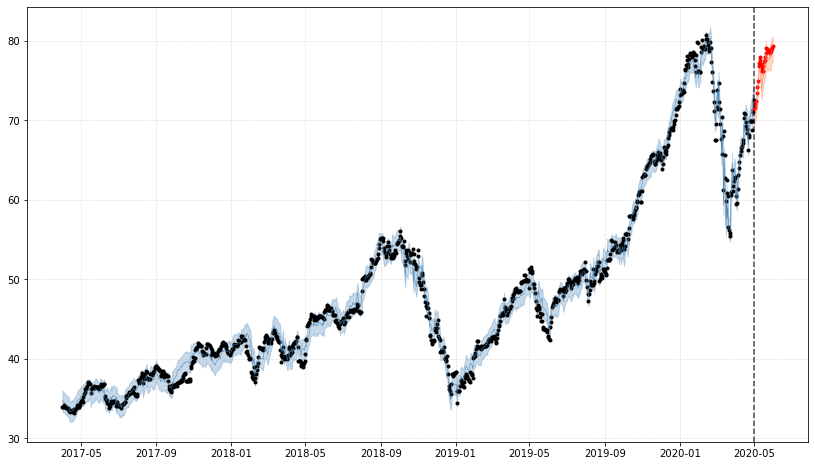

In [72]:
f, ax = plot_predictions(result, '2017-04-01')

C:\Users\Tharun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.05, 0.85, 'Skewness = -1.10\nMedian = -0.91\nMean = -0.96')

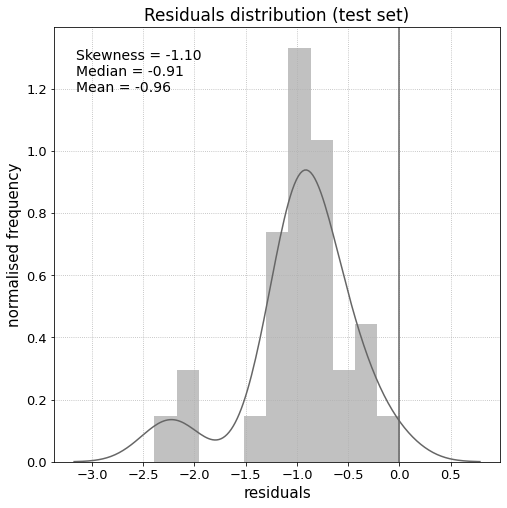

In [73]:
residuals = result.loc['2020-05-01':,'yhat'] - result.loc['2020-05-01':,'y']

f, ax = plt.subplots(figsize=(8,8))
sn.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(stats.skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

In [74]:
print('Mean Squared Error:', MSE(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))
print('Mean Absolute Error:', MAE(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))
print('R-Squared:', R2(result.loc['2020-05-01':,'y'].values, result.loc['2020-05-01':,'yhat'].values))


Mean Squared Error: 1.1903324741607988
Mean Absolute Error: 0.9650409599778853
R-Squared: 0.7859066090066532
